In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
    print("setup done")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

setup done
setup done
setup done
setup done
setup done
setup done
setup done
setup done
setup done
setup done
setup done
setup done


In [ ]:
import os
import cv2
from pathlib import Path

input_base_dir = "/kaggle/input/underwater-garbagedebris/Underwater_garbage"
output_base_dir = "/kaggle/working/"

def enhance_image(image_path, output_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    img_clahe = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)
    # Bilateral filter for noise reduction
    img_denoised = cv2.bilateralFilter(img_clahe, d=5, sigmaColor=25, sigmaSpace=25)
    # Light sharpening for edge clarity
    gaussian = cv2.GaussianBlur(img_denoised, (5, 5), 1.0)
    img_final = cv2.addWeighted(img_denoised, 1.3, gaussian, -0.3, 0)
    cv2.imwrite(output_path, img_final)

for split in ['train', 'valid', 'test']:
    src_img_dir = os.path.join(input_base_dir, split, 'images')
    dst_img_dir = os.path.join(output_base_dir, split, 'images')
    os.makedirs(dst_img_dir, exist_ok=True)
    
    if not os.path.exists(src_img_dir):
        print(f"Image directory not found for {split}: {src_img_dir}")
        continue
    
    for img_file in os.listdir(src_img_dir):
        if img_file.lower().endswith(('.jpg', '.png')):
            src_path = os.path.join(src_img_dir, img_file)
            dst_path = os.path.join(dst_img_dir, img_file)
            enhance_image(src_path, dst_path)
    
    print(f"Enhanced images for {split} split: {len(os.listdir(dst_img_dir))} images processed")

print("Image enhancement completed!")

Enhanced images for train split: 3628 images processed
Enhanced images for valid split: 1001 images processed
Enhanced images for test split: 501 images processed
Image enhancement completed!


In [ ]:
import os
import shutil

input_base_dir = "/kaggle/input/underwater-garbagedebris/Underwater_garbage"
output_base_dir = "/kaggle/working/"

for split in ['train', 'valid', 'test']:
    src_label_dir = os.path.join(input_base_dir, split, 'labels')
    dst_label_dir = os.path.join(output_base_dir, split, 'labels')
    
    if not os.path.exists(src_label_dir):
        print(f"Source directory not found: {src_label_dir}")
        continue
    
    if os.path.exists(dst_label_dir):
        shutil.rmtree(dst_label_dir)  
    shutil.copytree(src_label_dir, dst_label_dir)
    
    print(f"Copied labels from {src_label_dir} to {dst_label_dir}")
    
    label_files = [f for f in os.listdir(dst_label_dir) if f.endswith('.txt')]
    print(f"{split} - Copied {len(label_files)} label files")

print("Label copying completed!")

Copied labels from /kaggle/input/underwater-garbagedebris/Underwater_garbage/train/labels to /kaggle/working/train/labels
train - Copied 3628 label files
Copied labels from /kaggle/input/underwater-garbagedebris/Underwater_garbage/valid/labels to /kaggle/working/valid/labels
valid - Copied 1007 label files
Copied labels from /kaggle/input/underwater-garbagedebris/Underwater_garbage/test/labels to /kaggle/working/test/labels
test - Copied 501 label files
Label copying completed!


In [ ]:
import os
import shutil

output_base_dir = "/kaggle/working/"

# Weak class IDs to remove
weak_class_ids = {6, 12, 13}  # metal (6), rod (12), sunglasses (13)

def has_weak_class(label_path):
    if not os.path.exists(label_path):
        return False
    with open(label_path, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in weak_class_ids:
                return True
    return False

for split in ['train', 'valid', 'test']:
    src_img_dir = os.path.join(output_base_dir, split, 'images')
    src_label_dir = os.path.join(output_base_dir, split, 'labels')
    dst_img_dir = os.path.join(output_base_dir, f"{split}_cleaned", 'images')
    dst_label_dir = os.path.join(output_base_dir, f"{split}_cleaned", 'labels')
    
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_label_dir, exist_ok=True)
    
    if not os.path.exists(src_img_dir) or not os.path.exists(src_label_dir):
        print(f"Source directories not found for {split}")
        continue
    
    kept_images = 0
    for img_file in os.listdir(src_img_dir):
        if img_file.lower().endswith(('.jpg', '.png')):
            img_name = img_file.rsplit('.', 1)[0]
            label_file = f"{img_name}.txt"
            src_label_path = os.path.join(src_label_dir, label_file)
            
            if has_weak_class(src_label_path):
                continue
            
            shutil.copy(os.path.join(src_img_dir, img_file), os.path.join(dst_img_dir, img_file))
            if os.path.exists(src_label_path):  
                shutil.copy(src_label_path, os.path.join(dst_label_dir, label_file))
            kept_images += 1
    
    print(f"{split.capitalize()} split cleaned: {kept_images} images kept")

print("Weak classes (metal, rod, sunglasses) removed from enhanced folders!")

Train split cleaned: 3569 images kept
Valid split cleaned: 982 images kept
Test split cleaned: 497 images kept
Weak classes (metal, rod, sunglasses) removed from enhanced folders!


In [ ]:

#  Check mismatch and empty files images, labels
import os

base_dir = "/kaggle/working/"

for split in ['train_cleaned', 'valid_cleaned', 'test_cleaned']:
    label_dir = os.path.join(base_dir, split, 'labels')
    image_dir = os.path.join(base_dir, split, 'images')
    
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))]
    
    print(f"{split} - Images: {len(image_files)}, Labels: {len(label_files)}")
    
    # Convert image filenames to expected label filenames
    expected_label_files = [f.replace('.jpg', '.txt').replace('.png', '.txt') for f in image_files]
    missing_labels = set(expected_label_files) - set(label_files)
    if missing_labels:
        print(f"{split} - {len(missing_labels)} images without labels: {list(missing_labels)[:5]}")
    
    empty_labels = [f for f in label_files if os.path.getsize(os.path.join(label_dir, f)) == 0]
    if empty_labels:
        print(f"{split} - {len(empty_labels)} empty label files: {empty_labels[:5]}")


In [5]:
import os
from pathlib import Path

base_dir = "/kaggle/working/"

# Function to clean unmatched and empty labels
def clean_dataset(split):
    image_dir = f"{base_dir}{split}/images"
    label_dir = f"{base_dir}{split}/labels"
    
    # Ensure directories exist
    Path(image_dir).mkdir(parents=True, exist_ok=True)
    Path(label_dir).mkdir(parents=True, exist_ok=True)
    
    # Get file lists
    images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))]
    labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    img_names = set([os.path.splitext(f)[0] for f in images])
    lbl_names = set([os.path.splitext(f)[0] for f in labels])
    
    # Remove unmatched images and labels
    for img in img_names - lbl_names:
        img_path = os.path.join(image_dir, next(i for i in images if os.path.splitext(i)[0] == img))
        os.remove(img_path)
        print(f"Removed {img_path} (no label)")
    
    for lbl in lbl_names - img_names:
        lbl_path = os.path.join(label_dir, f"{lbl}.txt")
        os.remove(lbl_path)
        print(f"Removed {lbl_path} (no image)")
    
    # Remove empty label files and their images
    for lbl in lbl_names & img_names:  # Intersection: files with both image and label
        lbl_path = os.path.join(label_dir, f"{lbl}.txt")
        img_path = os.path.join(image_dir, next(i for i in images if os.path.splitext(i)[0] == lbl))
        if os.path.getsize(lbl_path) == 0:  # Empty file check
            os.remove(lbl_path)
            os.remove(img_path)
            print(f"Removed {lbl_path} (empty) and {img_path}")
    
    # Final count
    images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))]
    labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    print(f"{split} - Images: {len(images)}, Labels: {len(labels)}")

# Clean all splits
for split in ['train_cleaned', 'valid_cleaned', 'test_cleaned']:
    clean_dataset(split)

print("Dataset cleaning completed!")

Removed /kaggle/working/train_cleaned/labels/uwg_g-206_jpg.rf.0e70aebd7cc19101e245f5e964cb025a.txt (empty) and /kaggle/working/train_cleaned/images/uwg_g-206_jpg.rf.0e70aebd7cc19101e245f5e964cb025a.jpg
Removed /kaggle/working/train_cleaned/labels/uwg_g-846_jpg.rf.026c24929b46661866b000b45864b070.txt (empty) and /kaggle/working/train_cleaned/images/uwg_g-846_jpg.rf.026c24929b46661866b000b45864b070.jpg
train_cleaned - Images: 3567, Labels: 3567
Removed /kaggle/working/valid_cleaned/labels/uwg_g-198_jpg.rf.b796286997a9b6c8e05b8617737ad34d.txt (empty) and /kaggle/working/valid_cleaned/images/uwg_g-198_jpg.rf.b796286997a9b6c8e05b8617737ad34d.jpg
valid_cleaned - Images: 981, Labels: 981
test_cleaned - Images: 497, Labels: 497
Dataset cleaning completed!


In [ ]:
import os

output_base_dir = "/kaggle/working/"

# Mapping old IDs to new IDs
id_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 14: 11}

def reindex_label_file(label_path):
    if not os.path.exists(label_path):
        return
    with open(label_path, 'r') as f:
        lines = f.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        old_id = int(parts[0])
        if old_id in id_mapping:  # Only keep valid IDs
            new_id = id_mapping[old_id]
            new_lines.append(f"{new_id} {' '.join(parts[1:])}\n")
    with open(label_path, 'w') as f:
        f.writelines(new_lines)

# Reindex labels in all splits
for split in ['train_cleaned', 'valid_cleaned', 'test_cleaned']:
    label_dir = os.path.join(output_base_dir, split, 'labels')
    if not os.path.exists(label_dir):
        print(f"Label directory not found for {split}: {label_dir}")
        continue
    
    reindexed = 0
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            reindex_label_file(os.path.join(label_dir, label_file))
            reindexed += 1
    
    print(f"Reindexed {reindexed} label files in {split}")

print("Label reindexing completed!")

Reindexed 3567 label files in train_cleaned
Reindexed 981 label files in valid_cleaned
Reindexed 497 label files in test_cleaned
Label reindexing completed!


In [7]:
# Write new YAML with reindexed classes
yaml_content = """

train: /kaggle/working/train_cleaned/images
val: /kaggle/working/valid_cleaned/images
test: /kaggle/working/test_cleaned/images

nc: 12                     
names: ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove', 'misc', 'net', 'pbag', 'pbottle', 'plastic', 'tire']
cls_weights: [1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 4.0, 2.5]  
  
"""

with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(yaml_content)

print("Fixed YAML file created at /kaggle/working/data.yaml!")

Fixed YAML file created at /kaggle/working/data.yaml!


In [10]:
#!pip install ultralytics

In [11]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')  # Start with pretrained weights

# Train from scratch with focus on weak classes
results = model.train(
    data='/kaggle/working/data.yaml',  # Path to your data.yaml
    epochs=50,                         # 50 epochs (~50 min) for thorough training
    imgsz=640,                         # Image size
    device=0,                          # GPU device (use 'cpu' if no GPU)
    batch=16,                          # Batch size (~6-8GB GPU memory)
    workers=8,                         # Data loading threads
    patience=5,                       # Stop if no improvement after 10 epochs
    lr0=0.001,                         # Initial learning rate (slightly lower for stability)
    lrf=0.01,                          # Final learning rate factor
    optimizer='AdamW',                 # AdamW for better convergence
    cos_lr=True,                       # Cosine learning rate schedule
    dropout=0.1,                       # Regularization
    weight_decay=0.0005,               # Prevent overfitting
    augment=True,                      # Enable augmentation
    hsv_h=0.015,                       # Color augmentation
    hsv_s=0.7,                         # Strong saturation for weak class visibility
    hsv_v=0.4,                         # Value augmentation
    mosaic=1.0,                        # Full mosaic for context
    mixup=0.2,                         # Mixup for generalization
    close_mosaic=10,                   # Stop mosaic late to refine
    cls=3.0,                           # High classification weight for weak classes
    box=8.0,                           # High box weight for recall
    dfl=2.5,                           # Distribution focal loss for precise boxes
    pretrained=True,                   # Use pretrained backbone
    save=True,                         # Save checkpoints
    save_period=5,                     # Save every 5 epochs
    project='/kaggle/working/runs',    # Output directory
    name='pollution_detection_s_640_90_scratch'  # Run name
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 179MB/s]


Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=0, workers=8, project=/kaggle/working/runs, name=pollution_detection_s_640_90_scratch, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train_cleaned/labels... 3567 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3567/3567 [00:03<00:00, 1127.29it/s]


train: New cache created: /kaggle/working/train_cleaned/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/valid_cleaned/labels... 981 images, 0 backgrounds, 0 corrupt: 100%|██████████| 981/981 [00:00<00:00, 1313.71it/s]


val: New cache created: /kaggle/working/valid_cleaned/labels.cache
Plotting labels to /kaggle/working/runs/pollution_detection_s_640_90_scratch/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/pollution_detection_s_640_90_scratch
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.8G      1.776      16.66      2.966         86        640: 100%|██████████| 223/223 [01:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.08it/s]

                   all        981       1841      0.446      0.146      0.141     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.58G      1.802       14.4      3.034         68        640: 100%|██████████| 223/223 [01:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.23it/s]


                   all        981       1841      0.368      0.219      0.195     0.0975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.58G      1.829      14.31      3.081         59        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.49it/s]


                   all        981       1841       0.49       0.27       0.25      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.58G       1.78      13.66      3.023         57        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.38it/s]

                   all        981       1841      0.469      0.282      0.246      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.58G      1.747      13.03      2.977         80        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.44it/s]

                   all        981       1841      0.562      0.333      0.347        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.58G      1.729      12.63       2.97         51        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.43it/s]

                   all        981       1841      0.684      0.342      0.355      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.58G      1.681         12      2.897         54        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


                   all        981       1841      0.615      0.383      0.402      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.58G      1.694      11.91      2.908         55        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.46it/s]


                   all        981       1841      0.583      0.373      0.421      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.58G      1.628      11.33      2.816         66        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.693      0.412      0.462      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.58G      1.617      11.34       2.83         71        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.49it/s]

                   all        981       1841      0.699       0.42      0.466      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.58G      1.602      10.95      2.817        136        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]


                   all        981       1841       0.75      0.444      0.492      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.58G      1.583      10.65      2.778         64        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]

                   all        981       1841      0.583      0.391      0.437      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.58G      1.568      10.41      2.752         67        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


                   all        981       1841      0.558      0.458      0.507      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.58G      1.556      10.06      2.721         67        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]

                   all        981       1841      0.517      0.495      0.501      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.58G      1.556      10.06      2.739         88        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.502      0.482      0.489      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.58G      1.534      9.869      2.721         94        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


                   all        981       1841      0.585      0.524      0.562      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.58G      1.527      9.628      2.706         82        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


                   all        981       1841      0.591      0.487      0.543      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.58G      1.508      9.315      2.673         80        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


                   all        981       1841      0.577      0.535      0.572      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.58G      1.506      9.292      2.686         50        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


                   all        981       1841      0.646      0.535      0.585      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.58G      1.468      8.995      2.632         64        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]


                   all        981       1841      0.665      0.536      0.592      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.58G      1.469      8.851      2.631         63        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]

                   all        981       1841      0.679      0.584      0.619      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.58G      1.467      8.894      2.639         78        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]

                   all        981       1841      0.694      0.575      0.643      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.58G      1.461      8.734      2.629         83        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.751      0.552      0.648      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.58G      1.429      8.467      2.596         84        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


                   all        981       1841      0.633      0.584      0.637        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.58G       1.43      8.309      2.586         70        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.615      0.661      0.657      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.58G      1.436      8.198       2.58         50        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


                   all        981       1841      0.685      0.599      0.646      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.58G      1.403      7.915      2.547        118        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]


                   all        981       1841      0.649      0.618      0.653      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.58G      1.404      7.897      2.552         68        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.55it/s]


                   all        981       1841      0.737      0.647      0.689       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.58G      1.395      7.626      2.523         93        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.745      0.612      0.689      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.58G        1.4      7.636      2.525         70        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.52it/s]


                   all        981       1841      0.733      0.662      0.716       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.58G      1.371       7.44      2.508         71        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


                   all        981       1841      0.698      0.664      0.705      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.58G      1.377      7.486      2.517         77        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


                   all        981       1841      0.728       0.67      0.719      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.58G      1.357      7.282      2.492         84        640: 100%|██████████| 223/223 [01:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.737      0.683      0.733      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.58G      1.336      7.166      2.476         61        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


                   all        981       1841      0.765      0.662      0.737      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.58G      1.327      6.965      2.451         87        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


                   all        981       1841      0.745      0.657      0.733      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.58G      1.338      7.033      2.464        112        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]


                   all        981       1841      0.734      0.673      0.735      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.58G      1.297       6.72      2.421         62        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.48it/s]

                   all        981       1841       0.76       0.68      0.745      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.58G      1.327      6.894      2.452         66        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.717      0.716      0.755       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.58G      1.314      6.673      2.436         68        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]


                   all        981       1841      0.761      0.686      0.768      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.58G      1.283      6.453      2.394         51        640: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


                   all        981       1841      0.795      0.687      0.771      0.494
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.58G      1.161      4.583      2.303         33        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.52it/s]


                   all        981       1841      0.771      0.735      0.783      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.58G      1.141      4.164      2.266         16        640: 100%|██████████| 223/223 [01:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.55it/s]


                   all        981       1841      0.794      0.725      0.783      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.58G      1.128      3.996      2.252         41        640: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


                   all        981       1841      0.816      0.722      0.789      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.58G      1.119      3.967      2.256         19        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]


                   all        981       1841      0.802      0.753      0.804      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.58G      1.115      3.843      2.237         23        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]


                   all        981       1841      0.827      0.727      0.801      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.58G      1.108       3.84       2.23         35        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


                   all        981       1841      0.829       0.74      0.806      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.58G        1.1       3.83      2.227         26        640: 100%|██████████| 223/223 [01:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.49it/s]


                   all        981       1841       0.81      0.741      0.801      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.58G      1.101      3.784      2.222         51        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.55it/s]


                   all        981       1841       0.81      0.748      0.798      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.58G      1.098      3.733      2.222         29        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


                   all        981       1841      0.812      0.748        0.8      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.58G      1.097      3.736      2.223        105        640: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]

                   all        981       1841      0.814      0.754      0.808       0.53



50 epochs completed in 1.025 hours.
Optimizer stripped from /kaggle/working/runs/pollution_detection_s_640_90_scratch/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/runs/pollution_detection_s_640_90_scratch/weights/best.pt, 22.5MB

Validating /kaggle/working/runs/pollution_detection_s_640_90_scratch/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]


                   all        981       1841      0.842      0.762      0.832      0.558
                  Mask         77         90      0.986      0.811      0.935      0.694
                   can         18         20      0.825       0.55      0.698      0.294
             cellphone         60         70      0.923      0.971      0.984      0.872
           electronics         27         40      0.773      0.767      0.794      0.447
               gbottle         36         82      0.829      0.768      0.792      0.569
                 glove         37         55      0.942      0.891      0.961      0.794
                  misc         47         50      0.651      0.597      0.639      0.363
                   net        143        145      0.841       0.91      0.945      0.663
                  pbag        290        330        0.9       0.97      0.976      0.842
               pbottle        121        283      0.795      0.781      0.823        0.5
               plasti

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 14.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/pollution_detection_s_640_90_scratch


In [15]:
results = model.val(
    data='/kaggle/working/data.yaml',
    imgsz=640,
    device=0,
    batch=16
)
print(f"mAP@0.5: {results.box.map50:.3f}")
print(f"Precision: {results.box.mp:.3f}")
print(f"Recall: {results.box.mr:.3f}")
print("\nClass-wise mAP@0.5:")
for i, name in enumerate(results.names.values()):
    print(f"{name}: {results.box.maps[i]:.3f}")

Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/valid_cleaned/labels.cache... 981 images, 0 backgrounds, 0 corrupt: 100%|██████████| 981/981 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:30<00:00,  2.03it/s]


                   all        981       1841      0.836      0.765      0.833      0.558
                  Mask         77         90      0.985      0.811      0.935      0.691
                   can         18         20      0.816       0.55      0.698      0.293
             cellphone         60         70      0.921      0.971      0.984      0.871
           electronics         27         40      0.774      0.773      0.793      0.446
               gbottle         36         82      0.827      0.768      0.792      0.576
                 glove         37         55      0.942      0.893      0.961       0.79
                  misc         47         50      0.654      0.605      0.637      0.363
                   net        143        145      0.828       0.91      0.945      0.664
                  pbag        290        330      0.899       0.97      0.977      0.842
               pbottle        121        283      0.776      0.777      0.819        0.5
               plasti

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 26.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/pollution_detection_s_640_90_scratch5
mAP@0.5: 0.833
Precision: 0.836
Recall: 0.765

Class-wise mAP@0.5:
Mask: 0.691
can: 0.293
cellphone: 0.871
electronics: 0.446
gbottle: 0.576
glove: 0.790
misc: 0.363
net: 0.664
pbag: 0.842
pbottle: 0.500
plastic: 0.310
tire: 0.353


In [21]:
new_yaml="""

train: /kaggle/working/train_cleaned/images
val: /kaggle/working/valid_cleaned/images
test: /kaggle/working/test_cleaned/images

nc: 12
names: ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove', 'misc', 'net', 'pbag', 'pbottle', 'plastic', 'tire']
cls_weights: [1.0, 5.0, 1.0, 3.0, 2.0, 1.0, 6.0, 1.0, 1.0, 2.0, 7.0, 5.0]  
"""

with open('/kaggle/working/data_new.yaml', 'w') as f:
    f.write(new_yaml)

print("Fixed YAML file created at /kaggle/working/data_new.yaml!")

Fixed YAML file created at /kaggle/working/data_new.yaml!


In [22]:
from ultralytics import YOLO

# Load your latest model
model = YOLO('/kaggle/working/runs/pollution_detection_s_640_90_finetune2/weights/best.pt')

# Fine-tune with strong focus on weak classes
results = model.train(
    data='/kaggle/working/data_new.yaml',
    epochs=15,                         # 15 epochs (~15 min)
    imgsz=640,
    device=0,
    batch=16,
    workers=8,
    patience=5,                        # Stop if no gain after 5 epochs
    lr0=0.0005,                        # Higher LR to push weak classes
    lrf=0.005,
    optimizer='AdamW',
    cos_lr=True,
    dropout=0.2,
    weight_decay=0.001,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.9,                         # Max saturation for weak class visibility
    hsv_v=0.6,
    mosaic=1.0,                        # Full mosaic for context
    mixup=0.4,                         # Stronger mixup
    close_mosaic=10,                   # Keep mosaic until late
    cls=6.0,                           # Very high classification focus
    box=15.0,                          # Max focus on recall
    dfl=4.0,                           # Precise boxes
    pretrained=False,                  # Use your weights
    save=True,
    save_period=5,
    project='/kaggle/working/runs',
    name='pollution_detection_s_640_90_finetune_perfect'
)

Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/pollution_detection_s_640_90_finetune2/weights/best.pt, data=/kaggle/working/data_new.yaml, epochs=15, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=0, workers=8, project=/kaggle/working/runs, name=pollution_detection_s_640_90_finetune_perfect, exist_ok=False, pretrained=False, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

train: Scanning /kaggle/working/train_cleaned/labels.cache... 3567 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3567/3567 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/valid_cleaned/labels.cache... 981 images, 0 backgrounds, 0 corrupt: 100%|██████████| 981/981 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.79G      2.755      17.22      4.184        112        640: 100%|██████████| 223/223 [01:07<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.58it/s]


                   all        981       1841      0.756      0.584      0.672      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      4.57G      2.759      17.13      4.192         84        640: 100%|██████████| 223/223 [01:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.52it/s]


                   all        981       1841      0.721       0.69      0.738      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      4.57G      2.705      16.98      4.166         86        640: 100%|██████████| 223/223 [01:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.52it/s]


                   all        981       1841      0.771      0.612      0.707      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      4.57G      2.708      16.77      4.165         69        640: 100%|██████████| 223/223 [01:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


                   all        981       1841      0.728      0.663      0.714      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      4.57G      2.658      16.55      4.133         98        640: 100%|██████████| 223/223 [01:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


                   all        981       1841      0.762      0.652      0.738      0.469
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      4.57G      2.287      10.24      3.785         66        640: 100%|██████████| 223/223 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.46it/s]


                   all        981       1841      0.811      0.666      0.755      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      4.57G      2.229      9.234      3.724         27        640: 100%|██████████| 223/223 [01:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]

                   all        981       1841      0.774        0.7      0.753      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      4.57G      2.221      8.904      3.711         17        640: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]


                   all        981       1841      0.741      0.711      0.753      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      4.57G      2.181      8.482      3.668         54        640: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]

                   all        981       1841      0.827      0.714       0.79        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      4.57G      2.145      8.088      3.626         25        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


                   all        981       1841      0.811      0.757      0.812      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      4.57G      2.112       7.65      3.591         48        640: 100%|██████████| 223/223 [01:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.58it/s]


                   all        981       1841      0.835      0.754      0.821      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      4.57G      2.064      7.396      3.538         28        640: 100%|██████████| 223/223 [01:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


                   all        981       1841      0.839      0.748      0.822      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      4.57G      2.037      7.141      3.515         81        640: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.53it/s]


                   all        981       1841      0.837       0.76      0.835      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      4.57G       2.02      7.136      3.516         36        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.58it/s]


                   all        981       1841      0.844       0.76      0.834      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      4.57G      2.038      7.066      3.503         23        640: 100%|██████████| 223/223 [01:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.57it/s]


                   all        981       1841      0.855      0.758      0.836      0.537

15 epochs completed in 0.309 hours.
Optimizer stripped from /kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect/weights/best.pt, 22.5MB

Validating /kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]


                   all        981       1841      0.832      0.809       0.86      0.567
                  Mask         77         90      0.974      0.844      0.956      0.701
                   can         18         20      0.891      0.817      0.904       0.35
             cellphone         60         70      0.935      0.971      0.986      0.853
           electronics         27         40      0.753        0.8      0.784      0.446
               gbottle         36         82      0.829      0.768      0.784      0.565
                 glove         37         55      0.947      0.891      0.948      0.767
                  misc         47         50      0.673      0.699      0.756      0.441
                   net        143        145       0.85       0.91      0.953      0.668
                  pbag        290        330      0.867      0.985      0.981      0.846
               pbottle        121        283      0.738      0.816      0.811      0.491
               plasti

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 14.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect



0: 640x640 1 pbag, 11.8ms
1: 640x640 1 pbag, 11.8ms
2: 640x640 1 net, 11.8ms
3: 640x640 2 pbags, 11.8ms
4: 640x640 1 misc, 11.8ms
5: 640x640 1 pbottle, 11.8ms
6: 640x640 9 tires, 11.8ms
7: 640x640 1 net, 11.8ms
8: 640x640 1 pbag, 11.8ms
9: 640x640 1 net, 11.8ms
10: 640x640 4 tires, 11.8ms
11: 640x640 (no detections), 11.8ms
12: 640x640 3 pbags, 1 pbottle, 11.8ms
13: 640x640 1 pbag, 11.8ms
14: 640x640 1 pbag, 11.8ms
15: 640x640 1 tire, 11.8ms
16: 640x640 3 pbags, 1 pbottle, 11.8ms
17: 640x640 1 tire, 11.8ms
18: 640x640 1 pbottle, 11.8ms
19: 640x640 1 pbag, 11.8ms
Speed: 2.7ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


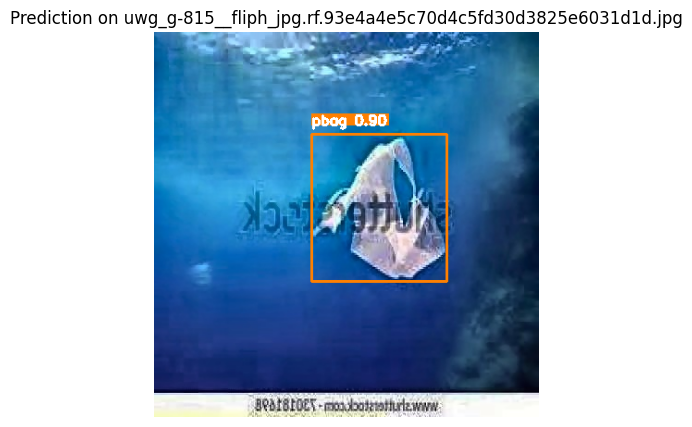

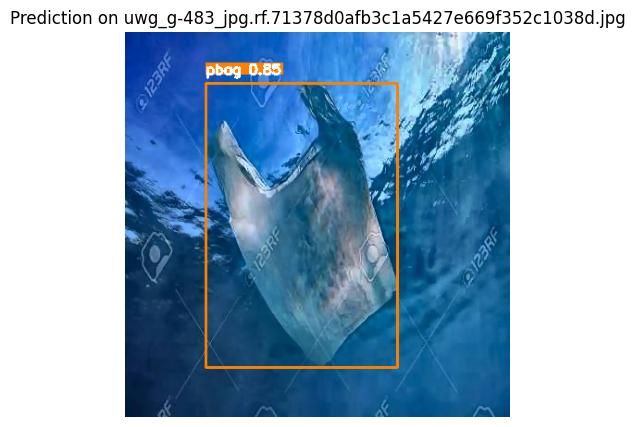

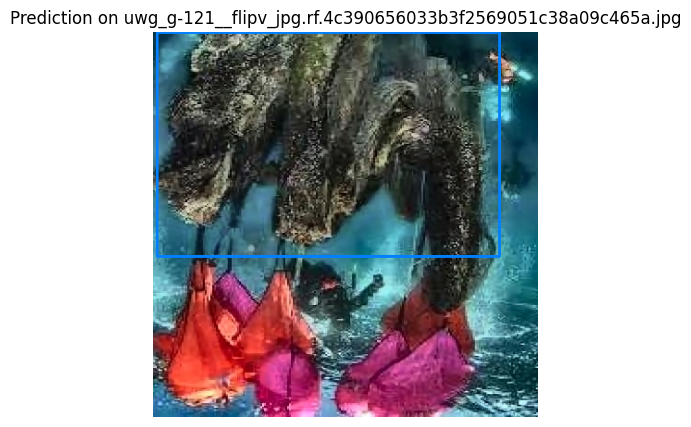

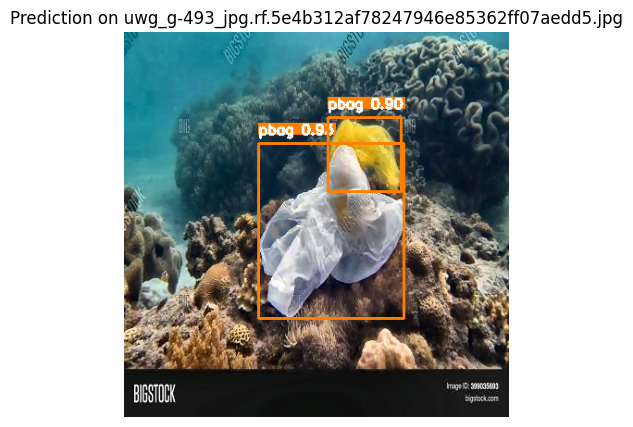

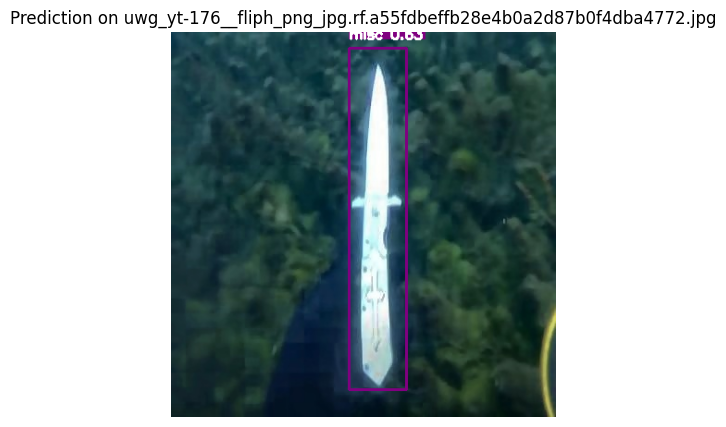

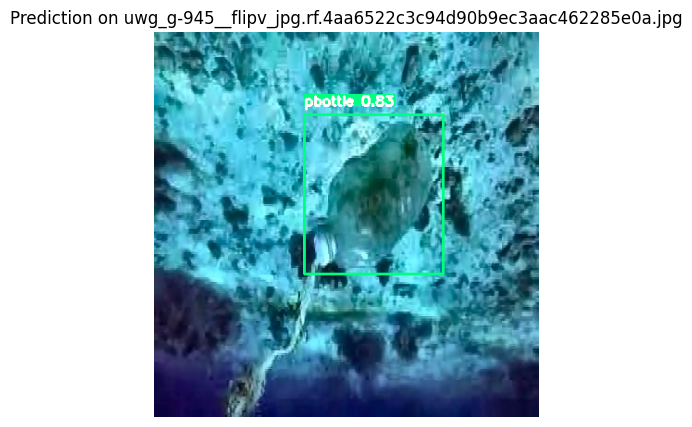

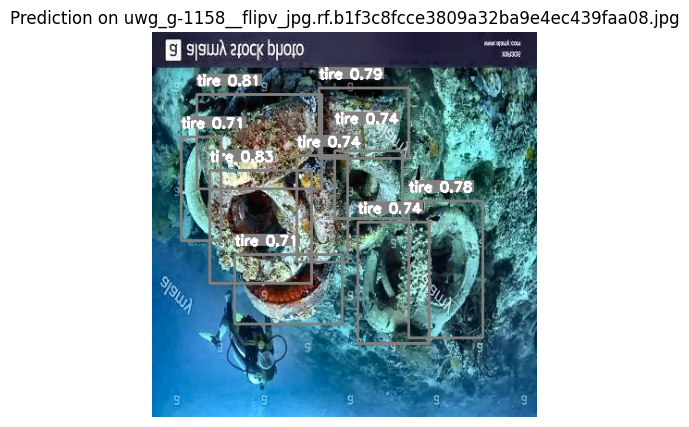

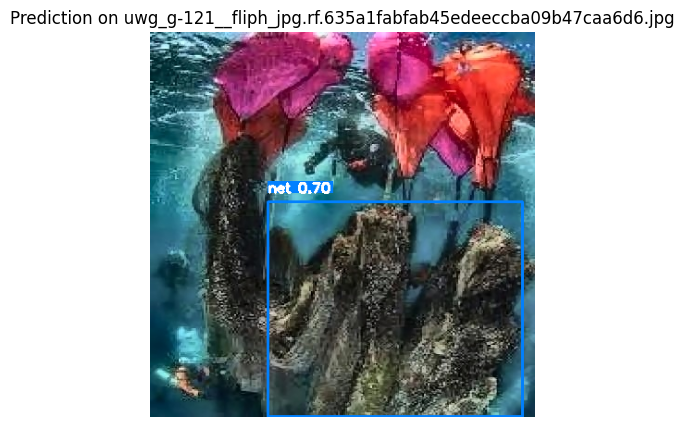

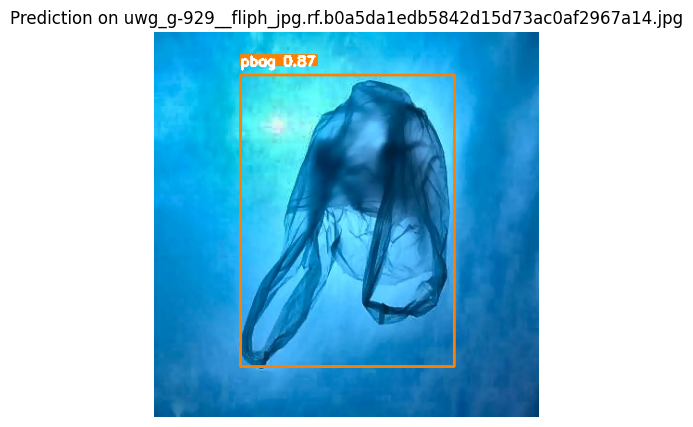

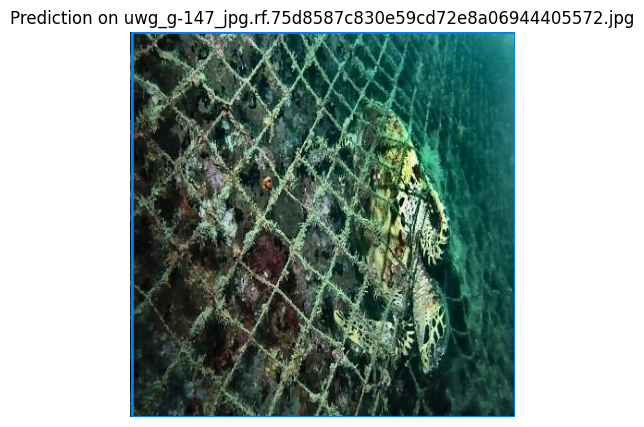

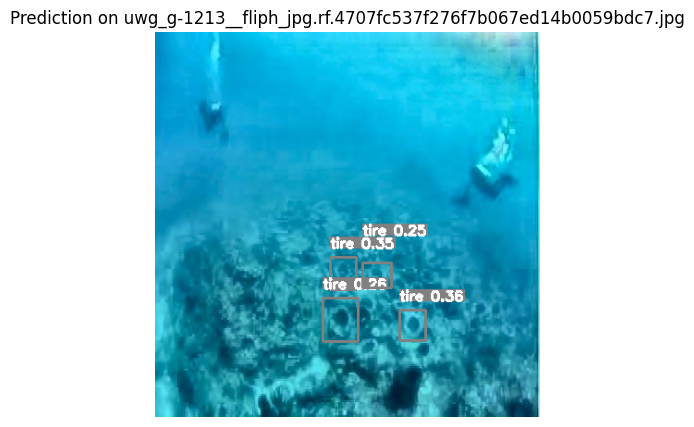

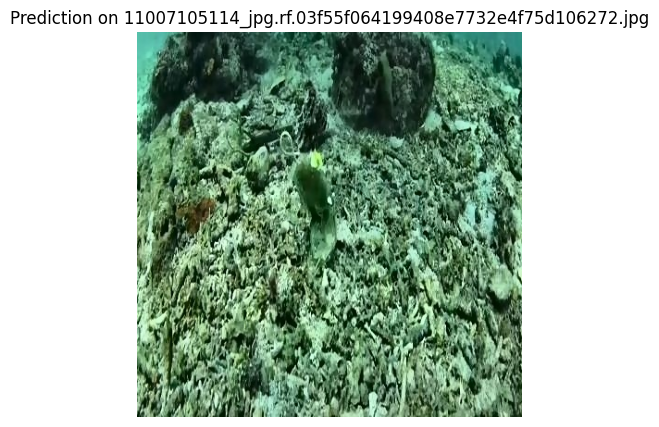

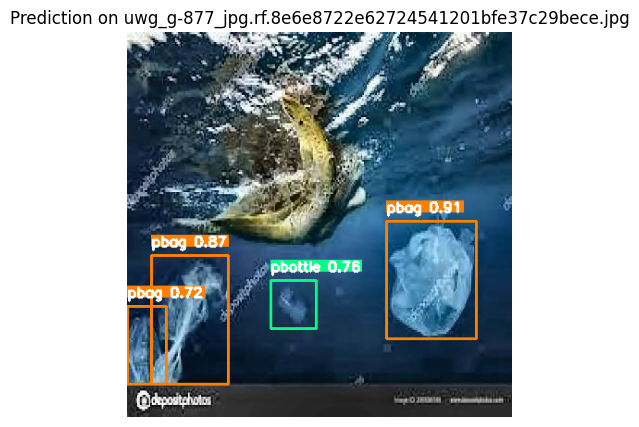

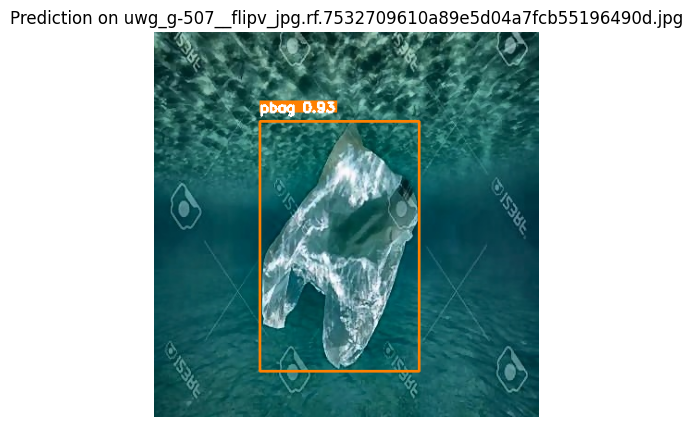

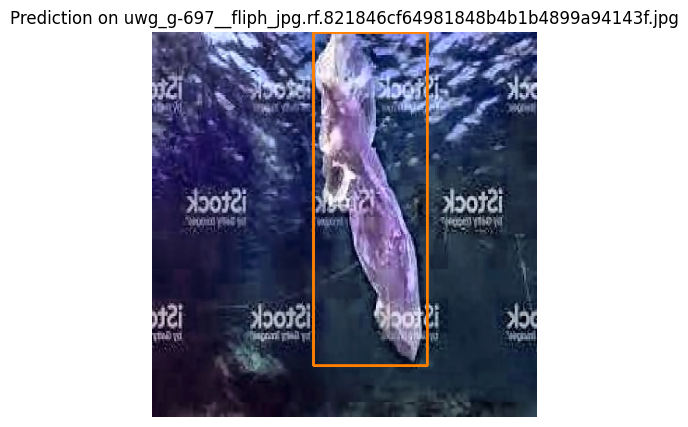

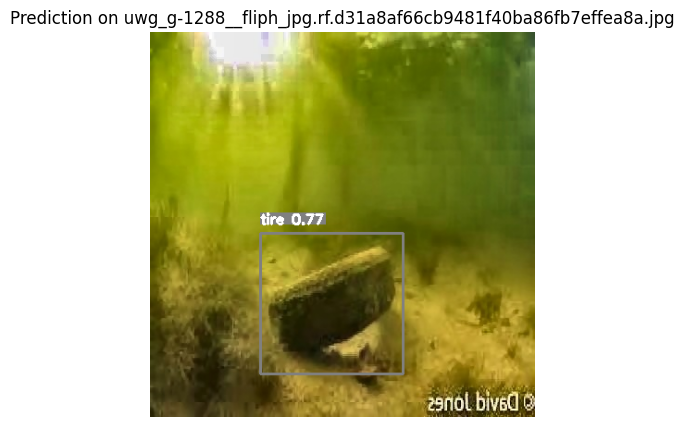

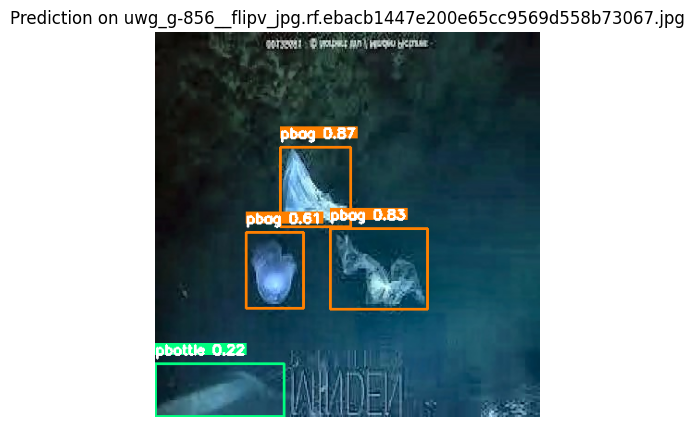

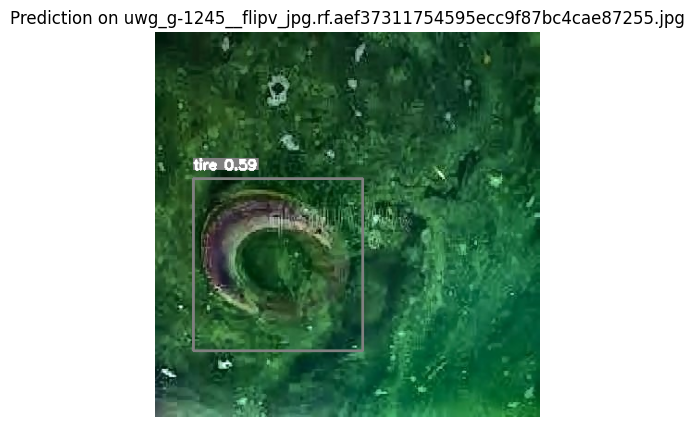

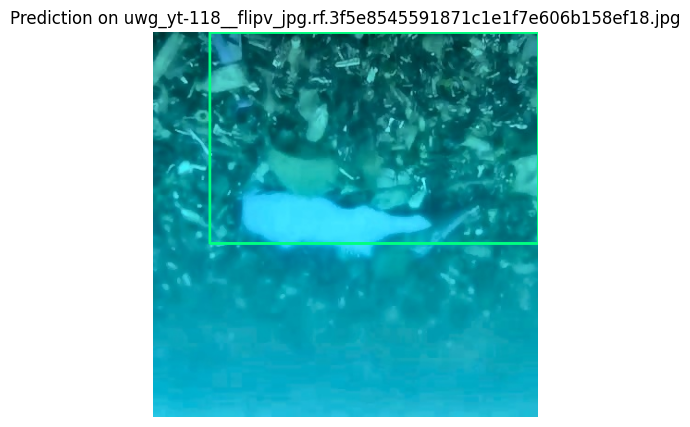

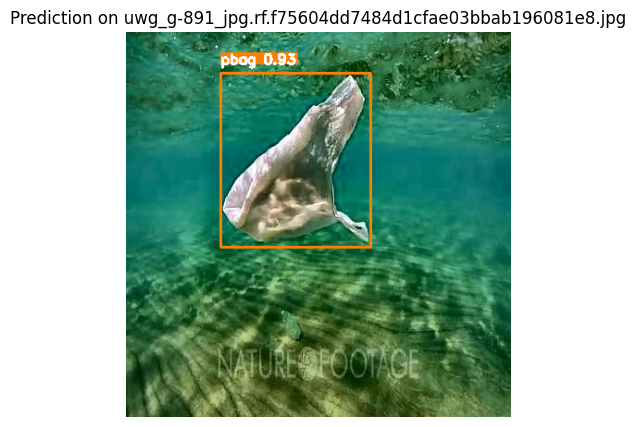


Image: /kaggle/working/valid_cleaned/images/uwg_g-815__fliph_jpg.rf.93e4a4e5c70d4c5fd30d3825e6031d1d.jpg
Detected: pbag, Confidence: 0.905

Image: /kaggle/working/valid_cleaned/images/uwg_g-483_jpg.rf.71378d0afb3c1a5427e669f352c1038d.jpg
Detected: pbag, Confidence: 0.851

Image: /kaggle/working/valid_cleaned/images/uwg_g-121__flipv_jpg.rf.4c390656033b3f2569051c38a09c465a.jpg
Detected: net, Confidence: 0.711

Image: /kaggle/working/valid_cleaned/images/uwg_g-493_jpg.rf.5e4b312af78247946e85362ff07aedd5.jpg
Detected: pbag, Confidence: 0.932
Detected: pbag, Confidence: 0.896

Image: /kaggle/working/valid_cleaned/images/uwg_yt-176__fliph_png_jpg.rf.a55fdbeffb28e4b0a2d87b0f4dba4772.jpg
Detected: misc, Confidence: 0.627

Image: /kaggle/working/valid_cleaned/images/uwg_g-945__flipv_jpg.rf.4aa6522c3c94d90b9ec3aac462285e0a.jpg
Detected: pbottle, Confidence: 0.830

Image: /kaggle/working/valid_cleaned/images/uwg_g-1158__flipv_jpg.rf.b1f3c8fcce3809a32ba9e4ec439faa08.jpg
Detected: tire, Confidence

In [39]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Load your best model
model = YOLO('/kaggle/working/runs/pollution_detection_s_640_90_finetune_perfect/weights/best.pt')

# Define test image paths (replace with your own if desired)
image_dir = '/kaggle/working/valid_cleaned/images/'  # Adjust if needed
test_images = [
    os.path.join(image_dir, img) for img in os.listdir(image_dir)[400:420]  # Test on 3 images
]  # Or specify: ['/path/to/test1.jpg', '/path/to/test2.jpg']

# Run inference
results = model.predict(
    source=test_images,
    imgsz=640,
    device=0,
    conf=0.2,           # Confidence threshold
    iou=0.6,            # IoU for NMS
    save=False
)

# Define unique colors for each class (in BGR format for OpenCV)
class_colors = {
    'Mask': (0, 255, 0),       # Green
    'can': (255, 0, 0),        # Blue
    'cellphone': (0, 0, 255),  # Red
    'electronics': (255, 255, 0),  # Cyan
    'gbottle': (0, 255, 255),  # Yellow
    'glove': (255, 0, 255),    # Magenta
    'misc': (128, 0, 128),     # Purple
    'net': (255, 128, 0),      # Orange
    'pbag': (0, 128, 255),     # Light Blue
    'pbottle': (128, 255, 0),  # Lime
    'plastic': (255, 0, 128),  # Pink
    'tire': (128, 128, 128)    # Gray
}

# Function to plot image with clear, non-overlapping labels
def plot_predictions(result, title):
    img = result.orig_img.copy()  # BGR format
    boxes = result.boxes
    labels = []

    # Collect all label positions to avoid overlap
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0]
        cls_id = int(box.cls[0])
        class_name = result.names[cls_id]
        label = f"{class_name} {conf:.2f}"
        color = class_colors.get(class_name, (0, 255, 0))  # Default to green if class not in dict

        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Calculate label position (above box, adjust if too close to others)
        text_x, text_y = x1, y1 - 10
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        label_h, label_w = label_size[1], label_size[0]

        # Check for overlap and adjust position
        for prev_x, prev_y, prev_w, prev_h in labels:
            if (abs(text_x - prev_x) < prev_w and abs(text_y - prev_y) < prev_h):
                text_y -= 20  # Move up if overlapping
        labels.append((text_x, text_y, label_w, label_h))

        # Draw label background for readability
        cv2.rectangle(img, (text_x, text_y - label_h), (text_x + label_w, text_y), color, -1)
        cv2.putText(img, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize predictions
for i, result in enumerate(results):
    image_name = os.path.basename(test_images[i])
    plot_predictions(result, f"Prediction on {image_name}")

# Print detection details
for i, result in enumerate(results):
    print(f"\nImage: {test_images[i]}")
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = box.conf[0]
        print(f"Detected: {result.names[cls_id]}, Confidence: {conf:.3f}")

In [ ]:
import os
import shutil

#os.remove('/kaggle/working/yolov8s.pt')
#shutil.rmtree('/kaggle/working/runs/pollution_detection_s_640_90_finetune')